In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df = pd.read_csv('../BNB_nue data/nue_and_mu_unscaled.csv', index_col=0)
df_scaled = pd.read_csv('../BNB_nue data/nue_and_mu_scaled.csv', index_col=0)
df['envelope'] = df_scaled ['envelope']
df['eps']=df_scaled['eps']
df['RSS'] = df_scaled['RSS']
df = df.dropna()
df.head()
len(df)

20232

In [3]:
variables = ['eps','RSS', 'envelope', 'nHits', 'sliding', 'pc2Var']


In [4]:
df_cut = df.loc[(df['completeness']>0.8) & (df['purity']>0.7) & (df['nHits']>4) ]
#df_cut = df.loc[(df['completeness']>0) & (df['purity']>0) & (df['nHits']>0) ]
len(df_cut)
df.head()
len(df_cut)

14517

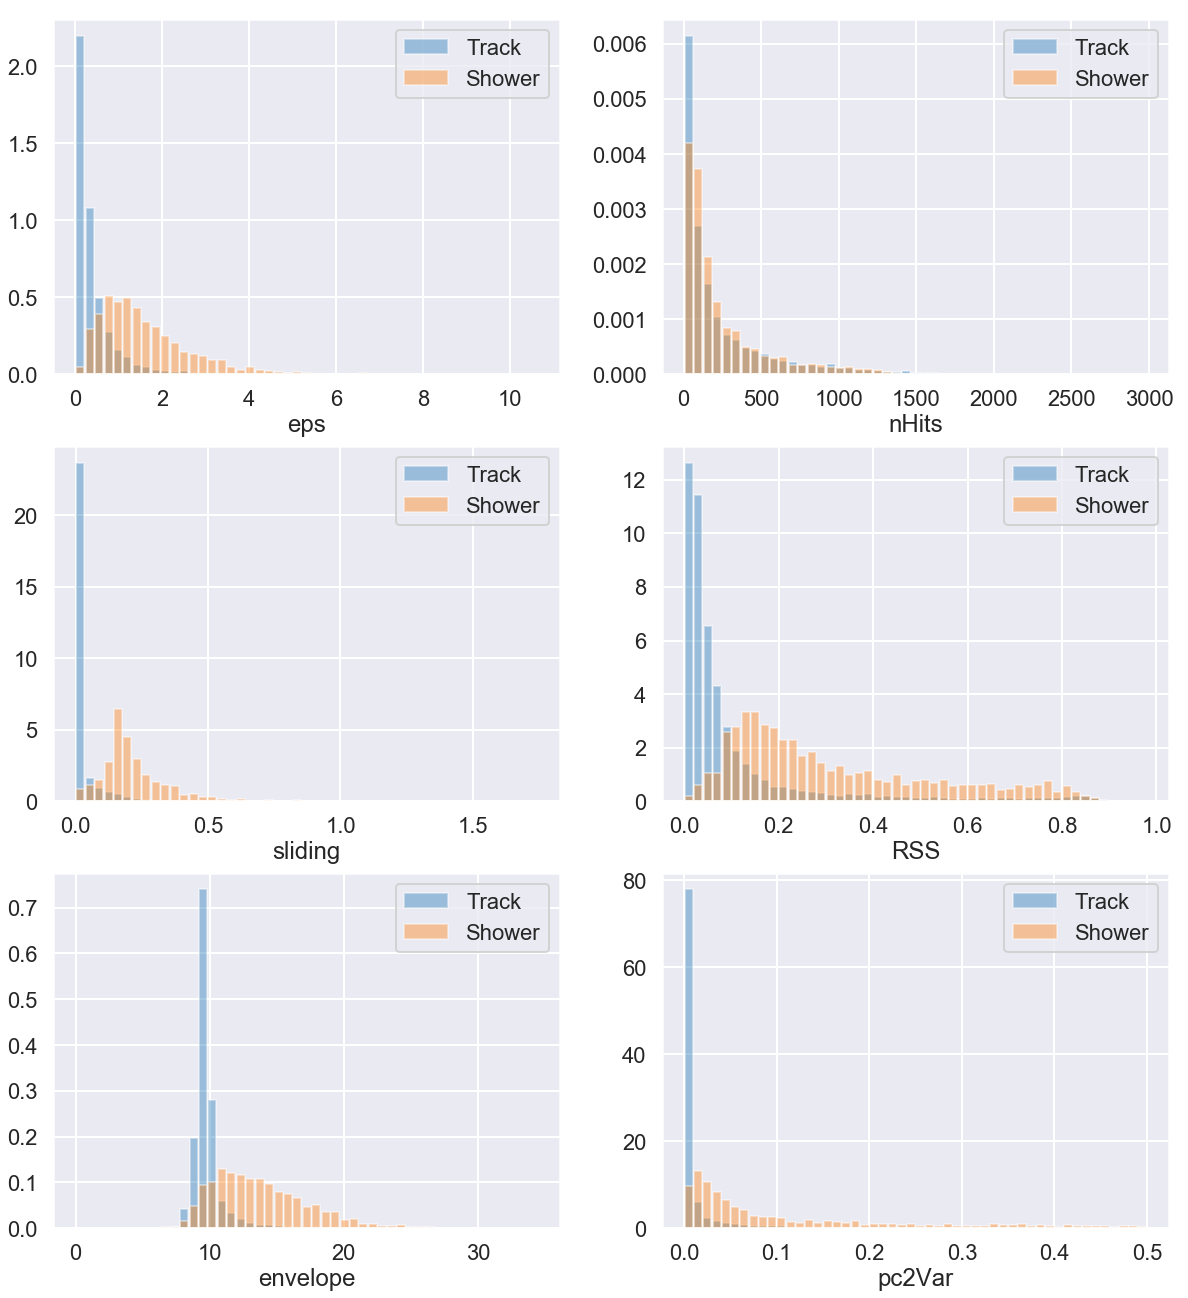

In [5]:
sns.set_style('darkgrid')
sns.set_context("poster")
length=3
width=2
fig, axarr = plt.subplots(length, width, figsize=(20,10))
plt.gcf().subplots_adjust(bottom=-0.8)
count=0
for i in range(len(variables)):
    bins = np.arange(min(df_cut[variables[i]]), max(df_cut[variables[i]]),(max(df_cut[variables[i]]) - min(df_cut[variables[i]]))/50)
    sns.distplot(df_cut[df_cut.isTrueTrack == 1][variables[i]],hist_kws = {"rwidth" :0.85},  bins=bins, label='Track',kde=False, norm_hist=True, ax=axarr[i%length][count%width])
    sns.distplot(df_cut[df_cut.isTrueTrack == 0][variables[i]],hist_kws = {"rwidth" :0.85}, bins= bins, label = 'Shower', kde=False, norm_hist=True, ax=axarr[i%length][count%width])
    plt.legend()
    axarr[i%length][count%width].legend()
    count+=1
    plt.close()
    
fig

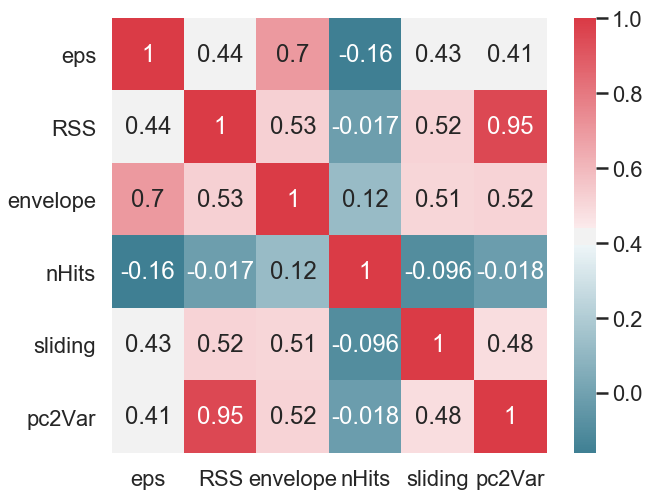

In [6]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_cut[variables].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = corr)
plt.show()

In [7]:
#train_variables = variables 
train_variables = ['eps','envelope', 'nHits','sliding', 'RSS']
X_train, X_test, y_train, y_test = train_test_split(df_cut[train_variables], df_cut['isTrueTrack'], test_size=0.5, random_state=42)

In [8]:
#clf=DecisionTreeClassifier(max_depth=6)
clf = GradientBoostingClassifier(max_depth=6, random_state=42)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
probabilities = clf.predict_proba(X_test)
prob = [probabilities[i][1] for i in range(len(X_test))]


confusion_matrix(y_test, y_pred), [[train_variables[i], clf.feature_importances_[i]] for i in range(len(train_variables))], accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)  

(array([[ 797,  155],
        [ 132, 6175]], dtype=int64),
 [['eps', 0.1650631063064161],
  ['envelope', 0.15357749961763401],
  ['nHits', 0.13959974776876277],
  ['sliding', 0.37670165357924035],
  ['RSS', 0.16505799272794686]],
 0.9604628736740598,
 0.97728891350795266)

In [9]:
X_test['prob']=prob
X_test['pred']=y_pred
X_test['isTrueTrack']=y_test

In [10]:
X_test.head()

,eps,envelope,nHits,sliding,RSS,prob,pred,isTrueTrack
16427,0.541,9.296094,131,0.009659,0.003240,0.998806,1,1
1430,0.891,12.842520,258,0.243246,0.142733,0.026305,0,0
2432,0.359,9.080003,16,0.007346,0.063127,0.998551,1,1
2440,0.835,11.182082,52,0.116953,0.212927,0.773069,1,1
11304,0.271,10.017737,891,0.012813,0.054891,0.999152,1,1


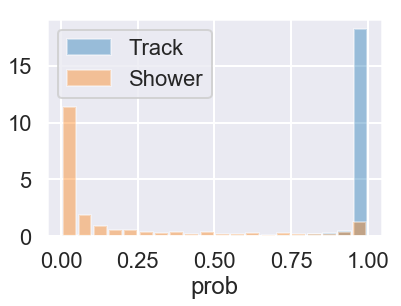

In [11]:
sns.distplot(X_test.loc[X_test['isTrueTrack']==1].prob,hist_kws = {"rwidth" : 0.85}, label='Track', kde=False, bins= 20, norm_hist=True)
sns.distplot(X_test.loc[X_test['isTrueTrack']==0].prob, label='Shower',hist_kws = {"rwidth" : 0.85}, kde=False, bins= 20, norm_hist=True)
plt.legend()
plt.show()


In [12]:
values = np.arange(0,1,0.005)
track_purity_=[]
track_completeness_=[]
p_ = sum(X_test.isTrueTrack)
for value in values:
    tp_ = len(X_test[(X_test.prob>value) & (X_test.isTrueTrack==1)])
    fp_ = len(X_test[(X_test.prob>value) & (X_test.isTrueTrack==0)])
    track_purity_.append(tp_/(tp_+fp_))
    track_completeness_.append(tp_/p_)

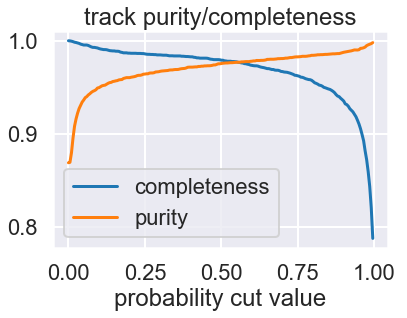

In [13]:
plt.plot(values, track_completeness_, label = 'completeness' )
plt.plot(values, track_purity_, label = 'purity')
plt.legend(loc = 'best')
plt.title('track purity/completeness')
plt.xlabel('probability cut value')
plt.show()